In [1]:
!rm -rf Covid_IC_Database/
!unzip './drive/My Drive/Dataset'

Archive:  ./drive/My Drive/Dataset.zip
   creating: Dataset/
   creating: Dataset/christopher_walken/
  inflating: Dataset/christopher_walken/face_detected_137dd371.jpg  
  inflating: Dataset/christopher_walken/face_detected_d0e3a4e5.jpg  
  inflating: Dataset/christopher_walken/face_detected_dd524fc0.jpg  
  inflating: Dataset/christopher_walken/face_detected_dfea8592.jpg  
  inflating: Dataset/christopher_walken/face_detected_33e400c5.jpg  
  inflating: Dataset/christopher_walken/face_detected_9284c7d2.jpg  
  inflating: Dataset/christopher_walken/face_detected_55cd03ed.jpg  
  inflating: Dataset/christopher_walken/face_detected_808b7ae7.jpg  
  inflating: Dataset/christopher_walken/face_detected_b9d342d1.jpg  
  inflating: Dataset/christopher_walken/face_detected_7e826a5e.jpg  
  inflating: Dataset/christopher_walken/face_detected_64c9d0b9.jpg  
  inflating: Dataset/christopher_walken/face_detected_ca96e0f8.jpg  
  inflating: Dataset/christopher_walken/face_detected_ae9506c8.jpg  
 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# data:
# person 1
#   photo0_1
#   photo0_2
#   ...
# person 2
#   photo1_1
#   photo1_2
#   ...
# ...


# train generator:
# input: users, batch_size

# anchor: users[u].img[i]
# positive: users[u].img[j], for i!= j
# negative: users[v].img[k], for v!=u

# base_model:
# architecture: resnet50 or vgg16 or vgg 19 -> dense layers with batch norm

# custom_layer(class):
# input: kwargs
# method: call(self, anchor_map, positive_map, negative_map) return distance_ap, distance_an

# Model:
# inputs = [base_model, base_model, base_model],
# outputs = [output_custom_layer] # computes distances between anchor -> positive, and anchor -> negative

# model:
# input: Model, margin
# methods: call(predict or inference), train_step, test_step

In [3]:
import glob, os
from skimage.transform import resize
import cv2 as cv
root_dir = './Dataset/'
def load_image(path):
  x = np.array(cv.imread(path))
  x = cv.cvtColor(x, cv.COLOR_BGR2RGB)
  return resize(x, (224,224,3))

data = []
for path, subdirs, files in os.walk(root_dir):
  for user in subdirs:
    v=[]
    for filename in glob.iglob(root_dir + user + '**/*.jpg', recursive=True):
      v.append(load_image(filename))

    v=np.array(v)
    data.append(v)

data = np.array(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [4]:
import numpy.linalg as nl

def create_model():
  base_model = tf.keras.applications.VGG16(include_top=False)
  model = tf.keras.Sequential(
      [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu', input_shape=(1, 7*7*512)),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Dense(128, activation='relu')
      ]
  )

  return model

class TripletModel(tf.keras.Model):

  def __init__(self, model):
    super(TripletModel, self).__init__()
    self.model = model
    # self.model_P = model_P
    # self.model_N = model_N
    self.n_hard_batches = 3

  def compile(self, loss, optimizer):
    super(TripletModel, self).compile()
    self.loss_fn = loss
    self.optimizer = optimizer

  def f(self, x):
    return nl.norm(x[0] - x[1]) - nl.norm(x[0] - x[2])

  def get_hard_triplets(self, triplets_batch):

    sorted_batches = sorted(
        triplets_batch,
        key=lambda x: self.f(x),
        reverse=True
    )
    return np.array(sorted_batches[:self.n_hard_batches])

  def train_gen(self, batch_sz):
    X = []
    Y = []
    global data
    for _ in range(batch_sz):
      # X_batch = tf.cast([], tf.float32)
      X_batch = []
      for __ in range(50):
        i = tf.experimental.numpy.random.randint(0, data.shape[0]) - 1
        user = data[i]
        j = tf.experimental.numpy.random.randint(0, user.shape[0]) - 1
        # anchor image
        anchor = user[j]
        k = tf.experimental.numpy.random.randint(0, user.shape[0]) - 1
        while (k==j):
          k = tf.experimental.numpy.random.randint(0, user.shape[0]) - 1
        # positive image
        positive = user[k]

        # now get some other user
        k = tf.experimental.numpy.random.randint(0, data.shape[0]) - 1
        while (k==i):
          k = tf.experimental.numpy.random.randint(0, data.shape[0]) - 1

        user_ = data[k]
        j = tf.experimental.numpy.random.randint(0, user_.shape[0]) - 1
        # negative image
        negative = user_[j]

        # tf.experimental.numpy.append(X_batch,
        #                 [tf.cast(anchor, tf.float32), 
        #                 tf.cast(positive, tf.float32), 
        #                 tf.cast(negative, tf.float32)])
        
        X_batch.append([anchor, positive, negative])

      hard_triplets = self.get_hard_triplets(X_batch)
      len_y = hard_triplets.shape[0]
      X += list(hard_triplets)
      Y += [np.zeros(3) for i in range(len_y)]

    return tf.cast(X, tf.float32), Y

  # @tf.function
  def train_step(self, data):
    X, Y = self.train_gen(15)

    with tf.GradientTape(persistent=True) as tape:
      input_A, input_P, input_N = tf.split(X, [1,1,1], axis=1)
      shape = tf.shape(input_A)
      shape = [shape[0], shape[2], shape[3], shape[4]]
      input_A = tf.reshape(input_A, shape)
      input_P = tf.reshape(input_P, shape)
      input_N = tf.reshape(input_N, shape)
      # print(f'Got inputs: {tf.shape(input_A)}, {tf.shape(input_P)}, {tf.shape(input_N)}')
      anchor = self.model(input_A)
      # print(f'Anchor output: {tf.shape(anchor)}')
      positive = self.model(input_P)
      # print(f'Positive output: {tf.shape(positive)}')
      negative = self.model(input_N)
      # print(f'Negative output: {tf.shape(negative)}')
      print()
      # print(f'-------- Got anchor, positive and negative outputs --------')

      y_pred = tf.cast([anchor, positive, negative], tf.float32)
      loss = self.loss_fn(y_pred)

    grad_A = tape.gradient(loss, self.model.trainable_variables)
    # grad_P = tape.gradient(loss, self.model_P.trainable_variables)
    # grad_N = tape.gradient(loss, self.model_N.trainable_variables)
    # print(f'Computed gradients')

    # print(f'Before: {model_A.layers[-1].weights}')
    self.optimizer.apply_gradients(zip(grad_A, self.model.trainable_variables))
    # print(f'After: {model_A.layers[-1].weights}')
    # self.optimizer.apply_gradients(zip(grad_P, self.model_P.trainable_variables))
    # self.optimizer.apply_gradients(zip(grad_N, self.model_N.trainable_variables))
    
    # print(f'Updated models')

    del tape, anchor, positive, negative, X, Y
    print(f'Loss value: {loss}')

    return {'loss': loss}

  def call(self, X):
    anchor, positive, negative = X

    anchor = self.model(anchor)
    positive = self.model(positive)
    negative = self.model(negative)

    return self.loss_fn(
        tf.cast([anchor, positive, negative], tf.float32)
    )


model = create_model()

58892288/58889256 [==============================] - 0s 0us/step


In [6]:
triplet_net = TripletModel(model)

In [7]:
@tf.function
def triplet_loss(y_pred, alpha = 0.2):
  anchor, positive, negative = tf.split(y_pred, [1,1,1], axis = 0)
  # tf.print(anchor, positive, negative)
  gap_ap = tf.reduce_sum(tf.square(anchor - positive), -1)
  gap_an = tf.reduce_sum(tf.square(anchor - negative), -1)
  # tf.print(gap_ap, gap_an)
  loss = gap_ap - gap_an + alpha
  loss = tf.maximum(loss, 0.0)
  # tf.print(loss)
  return tf.reduce_mean(loss)

# mnist = tf.keras.datasets.mnist
# (x,y), (_,_) = mnist.load_data()
triplet_net.compile(loss = triplet_loss, optimizer = tf.keras.optimizers.Adam(0.0001))
# triplet_net.fit(x=x, y=y, epochs=5)
for i in range(25):
  triplet_net.train_step(data)


Loss value: 2.1470603942871094

Loss value: 44.407230377197266

Loss value: 23.39089584350586

Loss value: 16.124927520751953

Loss value: 13.396468162536621

Loss value: 8.601335525512695

Loss value: 8.306015014648438

Loss value: 6.748994827270508

Loss value: 4.634608745574951

Loss value: 5.084203243255615

Loss value: 3.8827013969421387

Loss value: 3.223557472229004

Loss value: 3.562553644180298

Loss value: 2.525683641433716

Loss value: 1.5867233276367188

Loss value: 0.981884777545929

Loss value: 1.4620095491409302

Loss value: 1.9919488430023193

Loss value: 1.293642520904541

Loss value: 1.265907645225525

Loss value: 0.6680081486701965

Loss value: 0.2888599932193756

Loss value: 0.44529756903648376

Loss value: 0.6961942911148071

Loss value: 0.39868977665901184


Predict: True


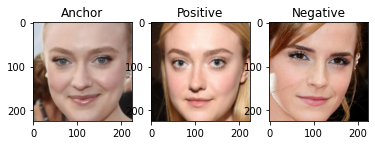

In [14]:
import matplotlib.pyplot as plt

anchor = data[7][3]
positive = data[7][4]
negative = data[9][1]

fig, ax = plt.subplots(1,3)
result = triplet_net(
    [anchor.reshape(1,224,224,3),
     positive.reshape(1,224,224,3),
     negative.reshape(1,224,224,3)]
)

print(f'Predict: {result < 0.2}')
ax[0].set_title('Anchor')
ax[0].imshow(anchor)
ax[1].set_title('Positive')
ax[1].imshow(positive)
ax[2].set_title('Negative')
ax[2].imshow(negative)
plt.show()

In [17]:
import joblib
joblib.dump(triplet_net, 'triplet_net')

TypeError: ignored